In [1]:
import os
import json

import numpy as np

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet, RidgeCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor, XGBRFRegressor
import xgboost as xgb

In [2]:
random_state = 42

In [3]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

In [4]:
def plot_feature_distributions(data, target):
    num_features = data.shape[1]
    num_rows = int(np.ceil((num_features + 1) / 2))
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))
    for i in range(num_features):
        row_idx = i // num_cols
        col_idx = i % num_cols
        sns.kdeplot(data[:, i], fill=True, ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Feature {i}')
        axes[row_idx, col_idx].set_xlabel('Value')
        axes[row_idx, col_idx].set_ylabel('Density')
    row_idx = num_features // num_cols
    col_idx = num_features % num_cols
    sns.kdeplot(target, fill=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title('Target')
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Density')
    for i in range(num_features + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, target):
    combined_data = np.column_stack((data, target))
    correlation_matrix = np.corrcoef(combined_data, rowvar=False)
    plt.figure(figsize=(13, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.6f', 
                xticklabels=[f'Feature {i}' for i in range(data.shape[1])] + ['Target'],
                yticklabels=[f'Feature {i}' for i in range(data.shape[1])] + ['Target'])
    plt.title('Correlation Matrix')
    plt.show()

In [5]:
# data normalization
scaler = StandardScaler()
data = scaler.fit_transform(data)

data = np.c_[data[:, 1], data[:, 3]]

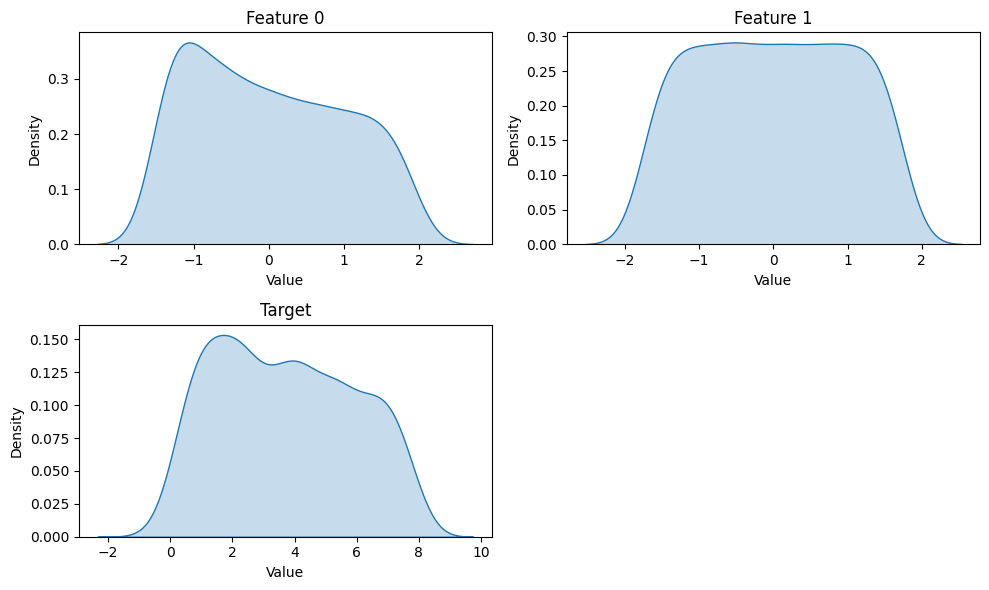

In [6]:
# feture distribution
plot_feature_distributions(data, target)

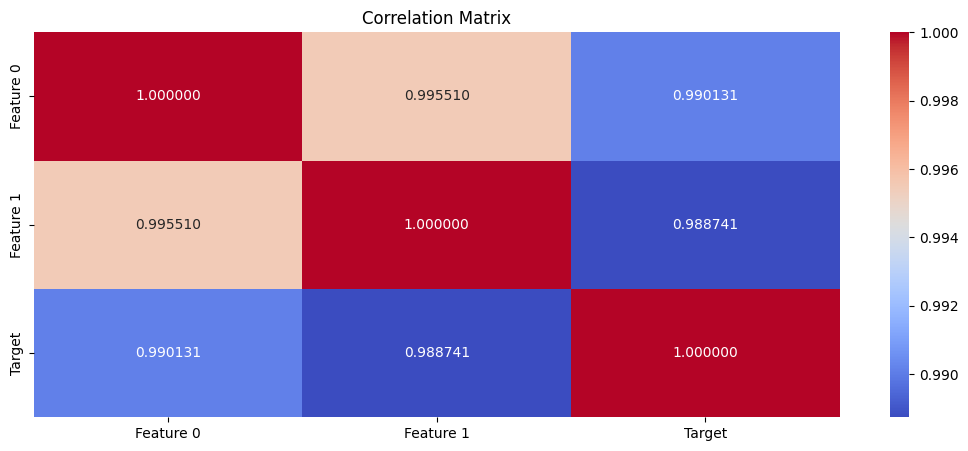

In [7]:
# correlation matrix
plot_correlation_matrix(data, target)

In [8]:
# feature selection
# feature_importance_model = RandomForestRegressor(random_state=random_state, n_jobs=-1)

# feature_importance_model.fit(data, target)
# feature_importances = feature_importance_model.feature_importances_
# print('Feature importances:\t\t', ',  '.join([f'{index}: {importance:.6f}' for index, importance in list(enumerate(feature_importances))]))
# sorted_features = sorted(list(enumerate(feature_importances)), key=lambda x: x[1], reverse=True)
# print('Sorted feature importances:\t', ',  '.join([f'{index}: {importance:.6f}' for index, importance in sorted_features]))
# sfm = SelectFromModel(feature_importance_model, threshold=0.16)
# data = sfm.fit_transform(data, target)
# selected_features = np.where(sfm.get_support())[0]
# print("Selected features:\t\t", ', '.join(map(str, selected_features)))

In [9]:
# par = {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.07996683461844337, 'subsample': 0.5422389721985905, 'colsample_bytree': 0.9458835365556577, 'gamma': 0.43424360382054583}

In [10]:
# model
base_models = [
    ('forest1', RandomForestRegressor(random_state=1, n_estimators=700, max_depth=7)),
    ('forest2', RandomForestRegressor(random_state=777, n_estimators=700, max_depth=7)),
]

meta_model = RidgeCV()

model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
# model = XGBRegressor(random_state=random_state)
# model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)

In [11]:
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 300),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.9),
#         'subsample': trial.suggest_float('subsample', 0.3, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1),
#         'gamma': trial.suggest_float('gamma', 0.1, 1.0),
#     }

#     model = XGBRegressor(random_state=random_state, **params)

#     score = -cross_val_score(model, data, target, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
#     return score

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500, n_jobs=-1)
# best_params = study.best_params
# model = XGBRegressor(random_state=random_state, **best_params)

In [12]:
# def objective(trial):
#     ridge_alpha = trial.suggest_float('ridge_alpha', 0.1, 2)
#     final_estimator_alpha = trial.suggest_float('final_estimator_alpha', 0.1, 2)

#     base_models = [
#         ('Ridge', Ridge(alpha=ridge_alpha, random_state=random_state)),
#         ('XGBRegressor', XGBRegressor(**par, random_state=random_state)),
#     ]
    
#     meta_model = Ridge(alpha=final_estimator_alpha, random_state=random_state)
    
#     model = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

#     score = -cross_val_score(model, data, target, cv=4, scoring='neg_mean_squared_error', n_jobs=-1).mean()
#     return score

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=200, n_jobs=-1)

# best_params = study.best_params
# best_score = study.best_value
# print("Best Parameters: ", best_params)
# print("Best Score: ", best_score)

In [13]:
# base_models = [
#     ('Ridge', Ridge(alpha=1.215898353743189, random_state=random_state)),
#     ('XGBRegressor', XGBRegressor(**par, random_state=random_state)),
# ]

# meta_model = Ridge(alpha=0.5376759333311283, random_state=random_state)

# model = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

In [14]:
# base_models = [
#     ('Ridge', Ridge(alpha=0.6683683832615862, random_state=random_state)),
#     ('XGBRegressor', XGBRegressor(n_estimators=107, learning_rate=0.01109026293862564, random_state=random_state)),
# ]

# meta_model = Ridge(random_state=random_state)

# model = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

In [15]:
# def objective(trial):
#     alpha_ridge = trial.suggest_float('alpha_ridge', 0.01, 4.0, log=True)

#     n_estimators_xgb = trial.suggest_int('n_estimators_xgb', 50, 200)
#     learning_rate_xgb = trial.suggest_float('learning_rate_xgb', 0.01, 0.5)

#     ridge = trial.suggest_float('ridge', 0.01, 4.0, log=True)

#     ridge_model = Ridge(alpha=alpha_ridge, random_state=random_state)
#     xgb_model = XGBRegressor(n_estimators=n_estimators_xgb, learning_rate=learning_rate_xgb, random_state=random_state)

#     base_models = [('Ridge', ridge_model), ('XGBRegressor', xgb_model)]
#     meta_model = Ridge(alpha=ridge, random_state=random_state)
#     model = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

#     score = -cross_val_score(model, data, target, cv=4, scoring='neg_mean_squared_error', n_jobs=-1).mean()
#     return score

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=400, n_jobs=-1)

# best_params = study.best_params
# best_score = study.best_value
# print("Best Parameters: ", best_params)
# print("Best Score: ", best_score)

In [16]:
# best_params

In [17]:
# base_models = [
#     ('Ridge', Ridge(alpha=0.6767672420701817, random_state=random_state)),
#     ('XGBRegressor', XGBRegressor(n_estimators=52, learning_rate=0.034900196698761224, random_state=random_state)),
# ]

# meta_model = Ridge(alpha=1.78873744360960, random_state=random_state)

# model = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

In [18]:
# cross validation
k_fold = KFold(n_splits=4, shuffle=True, random_state=random_state)
cv_scores = -cross_val_score(model, data, target, cv=k_fold, scoring='neg_mean_squared_error', n_jobs=-1)
mse = cv_scores.mean()
# mse = -grid_search.best_score_
# mse = best_score
print(f"Mean MSE: {mse:.4f}")
print(f"Points: {(1 - mse) * 1.5:.4f}")
print(f"STD MSE: {cv_scores.std():.4f}")
baseline_mse = 0.3467
print(f'Baseline MSE: {baseline_mse}')
print(f'Baseline points: {(1 - baseline_mse) * 1.5:.4f}')

Mean MSE: 0.1053
Points: 1.3420
STD MSE: 0.0036
Baseline MSE: 0.3467
Baseline points: 0.9799


In [19]:
# model fitting
model.fit(data, target)

StackingRegressor(estimators=[('forest1',
                               RandomForestRegressor(max_depth=7,
                                                     n_estimators=700,
                                                     random_state=1)),
                              ('forest2',
                               RandomForestRegressor(max_depth=7,
                                                     n_estimators=700,
                                                     random_state=777))],
                  final_estimator=RidgeCV())

In [20]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

In [21]:
# data normalization
closed_data = scaler.transform(closed_data)
# feature selection
# closed_data = sfm.transform(closed_data)
closed_data = np.c_[closed_data[:, 1], closed_data[:, 3]]

In [22]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

In [23]:
predicted_values = np.round(get_predictions(model=model, eval_data=closed_data), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

In [24]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.npy`')
# __________end of block__________

File saved to `submission_dict_final_p01.npy`
